In [2]:
import tensorflow as tf
import numpy as np


visualize = True
batch_size = 100
hidden_dim = 30
h1 = 500
h2 = 300
learning_rate = 0.0005
max_epochs = 10


train = np.array([[int(i) for i in line.split()] for line in open('../data/binarized_mnist_train.amat').readlines()]).astype('float32')
valid = np.array([[int(i) for i in line.split()] for line in open('../data/binarized_mnist_valid.amat').readlines()]).astype('float32')
test = np.array([[int(i) for i in line.split()] for line in open('../data/binarized_mnist_test.amat').readlines()]).astype('float32')

#---------------------------------------------------------------------------------------------------------#
x = tf.placeholder(tf.float32, shape=[None, 28*28])
phase_train = tf.placeholder(tf.bool)
z = tf.placeholder(tf.float32 , shape=[None,hidden_dim])
gen_image = tf.placeholder(tf.bool)

#---------------------------------------------------------------------------------------------------------#

with tf.name_scope("encoder"):
    ffd1 = tf.layers.dense(x, units=h1, activation=tf.nn.relu,use_bias=True, kernel_initializer = tf.contrib.layers.xavier_initializer() , bias_initializer = tf.constant_initializer(0.1))
    
    ffd2 = tf.layers.dense(ffd1, units=h2, activation=tf.nn.relu,use_bias=True, kernel_initializer = tf.contrib.layers.xavier_initializer() , bias_initializer = tf.constant_initializer(0.1))
    mu = tf.layers.dense(ffd2, units=hidden_dim, activation=None, kernel_initializer = tf.contrib.layers.xavier_initializer())
    sd = tf.layers.dense(ffd2, units=hidden_dim, activation=tf.nn.softplus, kernel_initializer = tf.contrib.layers.xavier_initializer())

    eps = tf.contrib.distributions.MultivariateNormalDiag(loc=[0.]*hidden_dim, scale_diag=[1.]*hidden_dim)
    samples = mu + eps.sample(tf.shape(sd)[0]) * sd

with tf.name_scope("decoder"):
    input_z = tf.where(gen_image,z,samples)

    ffd1_d = tf.layers.dense(input_z, units=h1, activation=tf.nn.relu, kernel_initializer = tf.contrib.layers.xavier_initializer(),bias_initializer = tf.constant_initializer(0.1))
    
    ffd2_d = tf.layers.dense(ffd1_d, units=h2, activation=tf.nn.relu, kernel_initializer = tf.contrib.layers.xavier_initializer(),bias_initializer = tf.constant_initializer(0.1))
    out = tf.layers.dense(ffd2_d, units = 28*28 , activation = None, kernel_initializer = tf.contrib.layers.xavier_initializer())

reconstructed_image = tf.nn.sigmoid(out) #> 0.5

likelihood = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=out),1)

likelihood_ = tf.reduce_mean(likelihood)

loss =  tf.reduce_mean(likelihood - tf.reduce_sum(0.5 * (1.+ tf.log(sd ** 2) - mu ** 2 - sd ** 2), 1))

train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
for _ in range(max_epochs):
    np.random.shuffle(train)
    for i in range(train.shape[0]/batch_size):
        batch = train[i*batch_size : (i+1)*batch_size, :]
        tr_lik, _ = sess.run([likelihood_, train_step], 
                             feed_dict={x:batch, phase_train:True, z:np.ones((100,hidden_dim)),gen_image:False})
        # print tr_lik
    test_lik = sess.run([likelihood_],
                        feed_dict={x:test[:100], phase_train:False, z:np.ones((100,hidden_dim)),gen_image:False})
    print "test : " + str(test_lik)

    val_lik = sess.run([likelihood_],
                       feed_dict={x:valid[:100], phase_train:False, z:np.ones((100,hidden_dim)),gen_image:False})
    print "validation : " + str(val_lik)


test : [138.71776]
validation : [121.65248]
test : [113.17545]
validation : [99.532341]
test : [104.42441]
validation : [92.59996]
test : [98.427933]
validation : [87.289314]
test : [93.935905]
validation : [83.002472]
test : [90.786766]
validation : [79.933739]
test : [88.861809]
validation : [78.50209]
test : [89.440422]
validation : [77.714813]
test : [88.906845]
validation : [77.318634]
test : [85.898415]
validation : [75.524521]


In [1]:
import tensorflow as tf
import numpy as np
import datetime
import socket
import os
import argparse


delta = 1e-12
batch_size = 100
hidden_dim = 30
num_transforms = 2
learning_rate = 0.0005
max_epochs = 20
scale_param = 10000

train = np.array([[int(i) for i in line.split()] for line in open('../data/binarized_mnist_train.amat').readlines()]).astype('float32')
valid = np.array([[int(i) for i in line.split()] for line in open('../data/binarized_mnist_valid.amat').readlines()]).astype('float32')
test = np.array([[int(i) for i in line.split()] for line in open('../data/binarized_mnist_test.amat').readlines()]).astype('float32')

def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        # mean = tf.reduce_mean(var)
        tf.summary.scalar('value',var)
        # with tf.name_scope('stddev'):
        #     stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        # tf.summary.scalar('stddev', stddev)
        # tf.summary.scalar('max', tf.reduce_max(var))
        # tf.summary.scalar('min', tf.reduce_min(var))
        # tf.summary.histogram('histogram', var)

# custom coupled layers
class realNVP:
    def __init__(self, name):
        self.name = name
        self.log_jacobian = None

    # forward pass through 2 real NVP layers
    def get_scale(self,name):
        scale = tf.get_variable(self.name+"_"+name+"_scale", [1], tf.float32, 
                                  tf.contrib.layers.xavier_initializer(),
                                  regularizer=tf.contrib.layers.l2_regularizer(5e-5))
        return scale
    def get_std(self, x):
        epsilon = 1e-3
        batch_mean, batch_var = tf.nn.moments(x,[0])
        # batch_std = 1.0/stf.sqrt(batch_var + epsilon)
        return batch_var + epsilon
    
    def forward(self, inp,phase_train):
        with tf.name_scope(self.name):
            dim = inp.shape[1]/2

            intermediate_top = inp[:, :dim]
            
            s1 = tf.layers.dense(intermediate_top, units=dim*2, activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer())
            s1 = tf.nn.relu(tf.layers.batch_normalization(s1,training = phase_train))
            s1 = tf.layers.dense(s1, units=dim, activation=tf.nn.tanh, kernel_initializer=tf.contrib.layers.xavier_initializer())

            t1 = tf.layers.dense(intermediate_top, units=dim*2, activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer())
            t1 = tf.nn.relu(tf.layers.batch_normalization(t1,training = phase_train))
            t1 = tf.layers.dense(t1, units=dim, activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer())
            
            intermediate_bot = inp[:, dim:] * tf.exp(s1) + t1

            outr_top = intermediate_bot
            
            s2 = tf.layers.dense(outr_top, units=dim*2, activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer())
            s2 = tf.nn.relu(tf.layers.batch_normalization(s2,training = phase_train))
            s2 = tf.layers.dense(s2, units=dim, activation=tf.nn.tanh, kernel_initializer=tf.contrib.layers.xavier_initializer())
            
            t2 = tf.layers.dense(intermediate_top, units=dim*2, activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer())
            t2 = tf.nn.relu(tf.layers.batch_normalization(t2,training = phase_train))
            t2 = tf.layers.dense(t2, units=dim, activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer())
            
            outr_bot = intermediate_top * tf.exp(s2) + t2

            self.log_jacobian = tf.reduce_sum(s1, 1) + tf.reduce_sum(s2, 1) #- 0.5 *tf.reduce_sum(tf.log(batch_std))

            return tf.concat([outr_bot,outr_top], 1)


    # backward pass through 2 real NVP layers
    def backward(inp):
        pass

#--------------------------------------------------------------------------------------------------------------------------------------------------------------------
x = tf.placeholder(tf.float32, shape=[None, 28*28])
phase_train = tf.placeholder(tf.bool)
z = tf.placeholder(tf.float32 , shape=[None,hidden_dim])
gen_image = tf.placeholder(tf.bool)


with tf.name_scope("encoder"):
    conv1 = tf.layers.conv2d(inputs=tf.reshape(x, [-1, 28, 28, 1]), 
                filters=32, kernel_size=[5, 5], kernel_initializer = tf.contrib.layers.xavier_initializer(),
                padding="same", activation=None)
    conv1 = tf.nn.relu(tf.layers.batch_normalization(conv1, training=phase_train))
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2,2], strides=(2, 2))

    conv2 = tf.layers.conv2d(inputs=pool1, filters=32, kernel_initializer = tf.contrib.layers.xavier_initializer(),
                kernel_size=[5, 5], padding="same", activation=None)
    conv2 = tf.nn.relu(tf.layers.batch_normalization(conv2, training=phase_train))
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2,2], strides=(2, 2))

    flat = tf.reshape(pool2, [-1, 32 * 7 * 7])
    mu = tf.layers.dense(flat, units=hidden_dim, activation=None, kernel_initializer = tf.contrib.layers.xavier_initializer())
    sd = tf.layers.dense(flat, units=hidden_dim, activation=tf.nn.softplus, kernel_initializer = tf.contrib.layers.xavier_initializer())

    dist = tf.contrib.distributions.MultivariateNormalDiag(loc=[0.]*hidden_dim, scale_diag=[1.]*hidden_dim)
    samples = mu + dist.sample(tf.shape(sd)[0]) * sd

#--------------------------------------------------------------------------------------------------------------------------------------------------------------------
with tf.name_scope("transformation"):
    rnvp = {}
    for idx in range(num_transforms):
        rnvp[idx] = realNVP("realNVP" + str(idx))
        samples = rnvp[idx].forward(samples,phase_train)

#--------------------------------------------------------------------------------------------------------------------------------------------------------------------
with tf.name_scope("decoder"):
    input_z = tf.where(gen_image,z,samples)
    flat = tf.layers.dense(input_z, units=32 * 7 * 7, activation=None, kernel_initializer = tf.contrib.layers.xavier_initializer())
    flat = tf.nn.relu(tf.layers.batch_normalization(flat, training=phase_train))
    deconv1 = tf.layers.conv2d_transpose(tf.reshape(flat, [-1, 7, 7, 32]), filters=32, kernel_size=[5,5], strides=(2, 2), padding='same', 
                        kernel_initializer = tf.contrib.layers.xavier_initializer(), activation=None)
    deconv1 = tf.nn.relu(tf.layers.batch_normalization(deconv1, training=phase_train))

    deconv2 = tf.layers.conv2d_transpose(deconv1, filters=32, kernel_size=[5,5], strides=(2, 2), padding='same', 
                        kernel_initializer = tf.contrib.layers.xavier_initializer(), activation=None)
    deconv2 = tf.nn.relu(tf.layers.batch_normalization(deconv2, training=phase_train))

    out = tf.layers.conv2d_transpose(deconv2, filters=1, kernel_size=[5,5], strides=(1, 1), padding='same', 
                        kernel_initializer = tf.contrib.layers.xavier_initializer(), activation=None)

reconstructed_image = tf.nn.sigmoid(out)
log_likelihood = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.reshape(x, [-1, 28, 28, 1]), logits=out), [1, 2, 3])

with tf.name_scope("likelihood"):
    likelihood_ = tf.reduce_mean(log_likelihood)

beta_t = 1.0

if not num_transforms:
    loss =  tf.reduce_mean(log_likelihood - 0.5 * tf.reduce_sum(1.+ tf.log(sd ** 2) - mu ** 2 - sd ** 2, 1))
else:
    loss = beta_t*log_likelihood + 0.5 * tf.reduce_sum(samples ** 2, 1) - 0.5 * tf.reduce_sum(tf.log(sd + delta), 1)
    for idx in range(num_transforms):
        loss -= rnvp[idx].log_jacobian
    loss = tf.reduce_mean(loss)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)


gpu_options = tf.GPUOptions()#per_process_gpu_memory_fraction=0.5)
gpu_options.allow_growth=True
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

sess.run(tf.global_variables_initializer())
iteration = 0
for _ in range(max_epochs):
    np.random.shuffle(train)
    for i in range(train.shape[0]/batch_size):
        iteration+=1
        batch = train[i*batch_size : (i+1)*batch_size, :]
    
        tr_lik, _ = sess.run([likelihood_, train_step], feed_dict={x:batch, phase_train:True, z:np.ones((100,hidden_dim)),gen_image:False})
    test_lik,test_loss= sess.run([likelihood_,loss], feed_dict={x:test[:100], phase_train:False, z:np.ones((100,hidden_dim)),gen_image:False})
    print "test likelihood: " + str(test_lik)
    val_lik,val_loss = sess.run([likelihood_,loss], feed_dict={x:valid[:100], phase_train:False, z:np.ones((100,hidden_dim)),gen_image:False})
    print "validation likelihood : " + str(val_lik)

test likelihood: 101.774
validation likelihood : 97.0176
test likelihood: 93.3697
validation likelihood : 83.2298
test likelihood: 86.6748
validation likelihood : 76.8052
test likelihood: 84.9689
validation likelihood : 74.7979
test likelihood: 79.7001
validation likelihood : 69.8444
test likelihood: 82.8358
validation likelihood : 73.1653
test likelihood: 76.5572
validation likelihood : 66.9409
test likelihood: 77.5914
validation likelihood : 67.1027
test likelihood: 77.7635
validation likelihood : 68.7702
test likelihood: 83.3277
validation likelihood : 71.6376
test likelihood: 76.5046
validation likelihood : 66.6255
test likelihood: 78.3827
validation likelihood : 66.0271
test likelihood: 74.718
validation likelihood : 63.4598
test likelihood: 76.3156
validation likelihood : 64.3734
test likelihood: 72.8195
validation likelihood : 64.0998
test likelihood: 73.4221
validation likelihood : 62.8064
test likelihood: 73.9398
validation likelihood : 61.3546
test likelihood: 72.4314
validat

In [3]:
import matplotlib.pyplot as plt

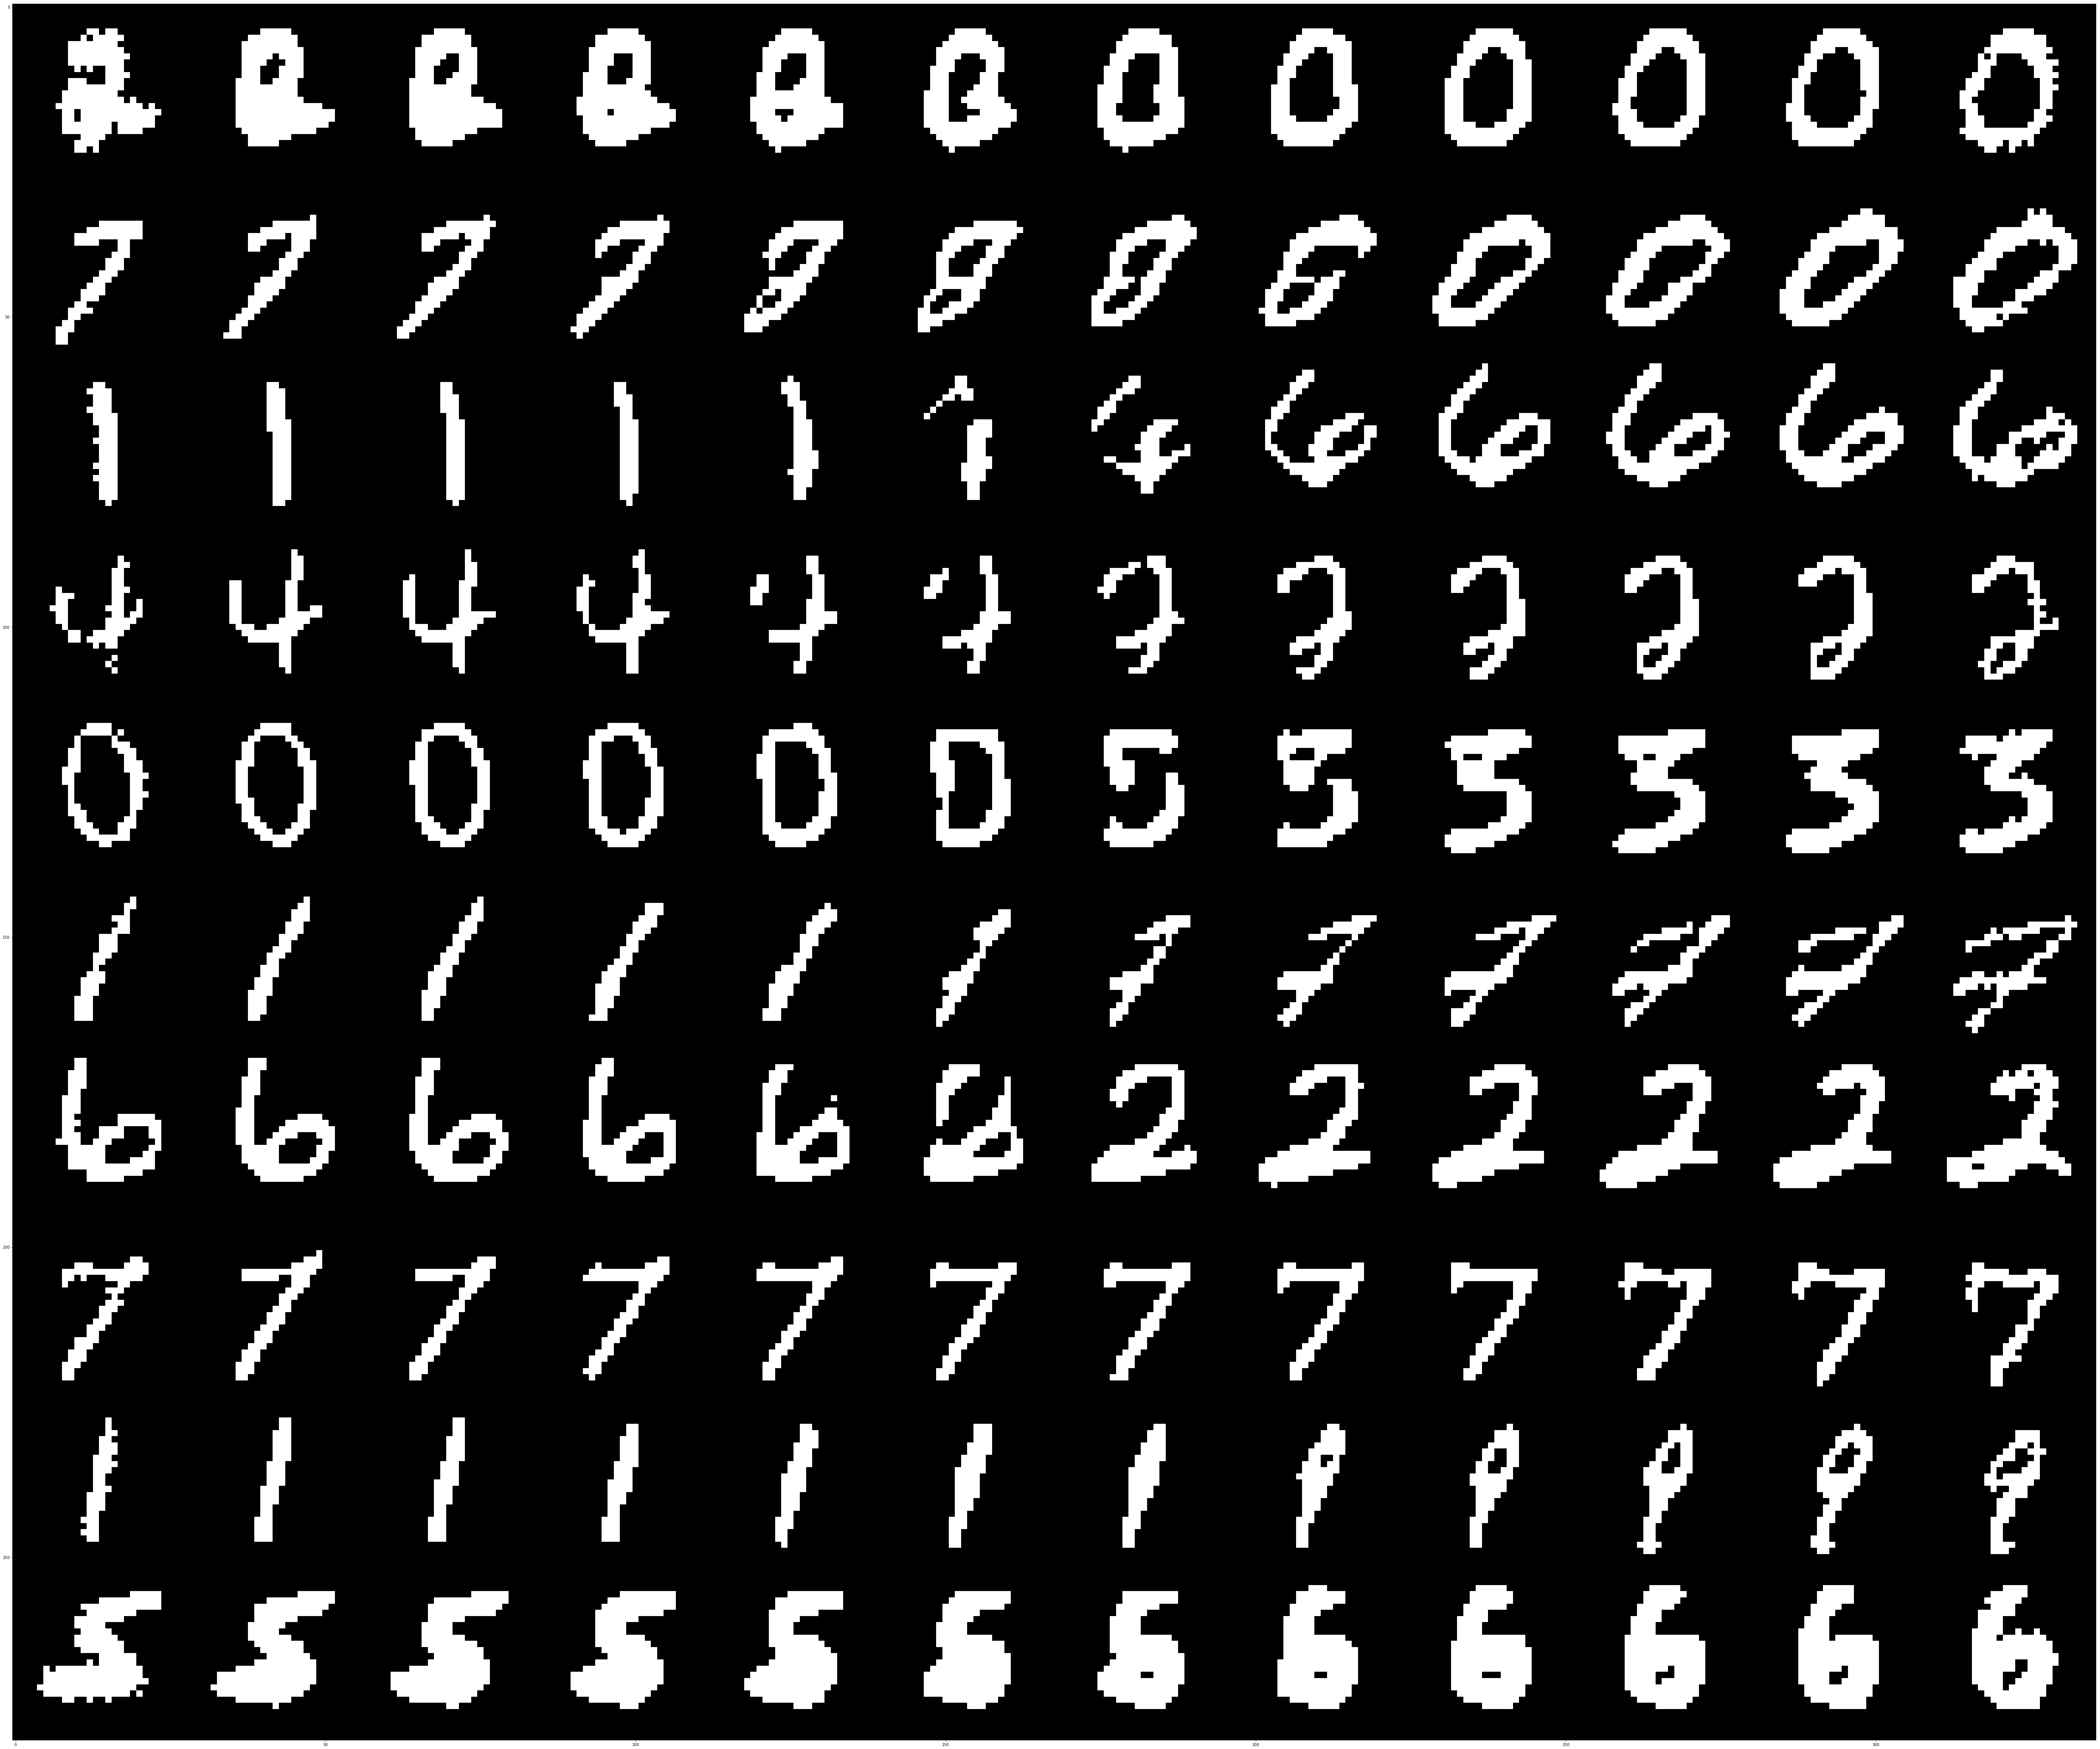

In [4]:
num_inter = 10
num_examples = 10
np.random.shuffle(test)
x_samples = test[:2*num_examples]
# print(x_samples.shape)
z_ = sess.run(samples,
               feed_dict={x: x_samples,phase_train : False,z:np.ones((2*num_examples,hidden_dim)),gen_image:False})
# z_2 = sess.run(samples,
#                feed_dict={x: x_samples[1:],phase_train : False,z:np.ones((1,hidden_dim)),gen_image:False})
# print(z_.shape)
ims = []
for j in xrange(num_examples):
    z_1 = z_[2*j]
    z_2 = z_[2*j+1]
#     print(i)
    alphaValues = np.linspace(0, 1,num_inter)
    x_samples_ = test[:num_inter]
    vector= np.zeros((num_inter,hidden_dim))
    for i,alpha in enumerate(alphaValues):
        vector[i] = z_1*(1-alpha) + z_2*alpha

    x_reconstruct =  sess.run(reconstructed_image,
                              feed_dict={x: x_samples_,phase_train : False,z:vector,gen_image:True})
#     print(i)
    
    im  = x_samples[2*j].reshape(28,28)
    for i in range(num_inter):
        im = np.hstack([im,x_reconstruct[i].reshape(28,28)>0.4])
    im = np.hstack([im,x_samples[2*j+1].reshape(28,28)])
    ims.append(im)
im_plt = ims[0]
for im in ims[1:]:
    im_plt = np.vstack([im_plt,im])

plt.figure(figsize=(100,100))
# plt.subplot(1,num_inter+2, 1)
plt.imshow(im_plt, vmin=0, vmax=1, cmap="gray")
# plt.title("original1")
plt.show()
    

if visualize:
    np.random.shuffle(test)
    x_samples = test[:100]
    x_reconstruct = sess.run(reconstructed_image, feed_dict={x: x_samples,phase_train : False})
    x_reconstruct = x_reconstruct>0.5
    plt.figure(figsize=(8, 12))
    for i in range(5):
        plt.subplot(5, 2, 2*i + 1)
        plt.imshow(x_samples[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
        plt.title("Test input")
        plt.colorbar()
        plt.subplot(5, 2, 2*i + 2)
        plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
        plt.title("Reconstruction")
        plt.colorbar()
    plt.tight_layout()

plt.show()

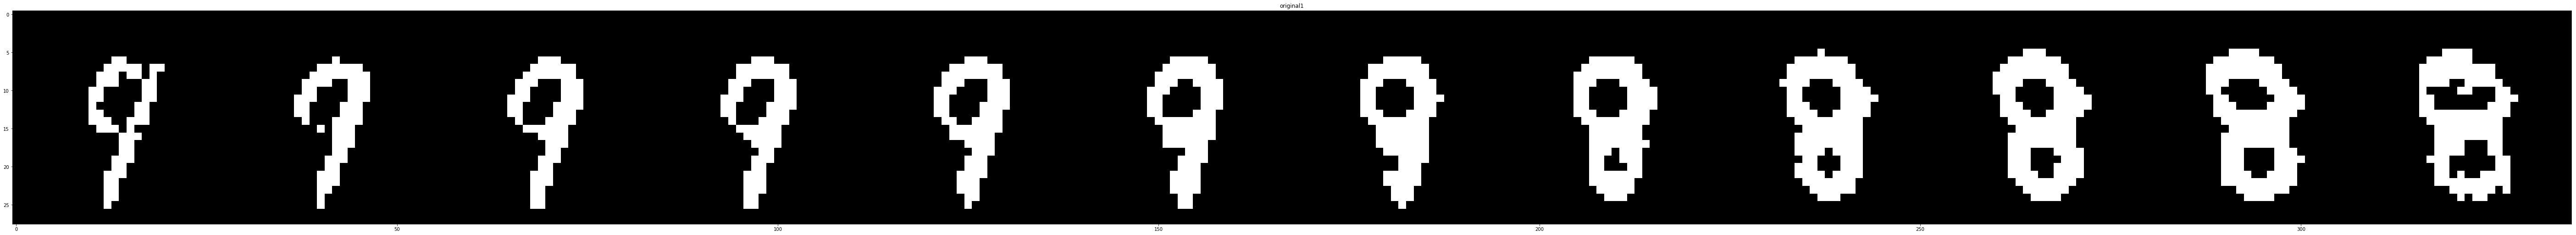

In [15]:
im  = x_samples[0].reshape(28,28)
for i in range(num_inter):
    im = np.hstack([im,x_reconstruct[i].reshape(28,28)>0.5])
im = np.hstack([im,x_samples[1].reshape(28,28)])
plt.figure(figsize=(100,100))
# plt.subplot(1,num_inter+2, 1)
plt.imshow(im, vmin=0, vmax=1, cmap="gray")
plt.title("original1")
plt.show()

In [12]:
plt.figure(figsize=(10,10))
plt.subplot(1,num_inter+2, 1)
plt.imshow(x_samples[0].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
plt.title("original1")
# plt.colorbar()

# im  = x_samples[0]
for i in range(num_inter):
    plt.subplot(1,num_inter+2, i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28)>0.5, vmin=0, vmax=1, cmap="gray")
#     plt.title("Interpolation")
#     plt.colorbar()
#     im = np.hstack(im,x_reconstruct[i])
# im = np.hstack(im,x_samples[0])

plt.subplot(1,num_inter+2,num_inter+2)
plt.imshow(x_samples[1].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
plt.title("original2")
# plt.colorbar()

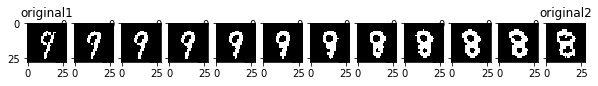

In [13]:
plt.show()

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [57]:
def weight_variable(shape, name=None):
    # break simmetry
    if name:
        w = tf.truncated_normal(shape, stddev=0.1, name=name)
    else:
        w = tf.truncated_normal(shape, stddev=0.1)

    return tf.Variable(w)


def bias_variable(shape, name=None):
    # avoid dead neurons
    if name:
        b = tf.constant(0.1, shape=shape, name=name)
    else:
        b = tf.constant(0.1, shape=shape)
    return tf.Variable(b)


In [58]:
hidden_dim = 30


def norm_layer(z):
    w = weight_variable([hidden_dim,1])
    b = bias_variable([1,])
    u = weight_variable([hidden_dim,1])
    
    # m = tf.layers.dense(z,1,activation=None, kernel_initializer = tf.contrib.layers.xavier_initializer(),bias_initializer = tf.constant_initializer(0.1)
                    

    m = tf.matmul(z,w) + b
    h = tf.nn.relu(m)
    
    out1 = z + tf.matmul(h,u,transpose_b = True)
    
    h_ = tf.gradients(h,m)[0]
    phi = tf.matmul(h_,w,transpose_b = True)
    out2 = tf.log(tf.abs(1 + tf.matmul(phi,u)))
    
    return out1, out2

        

z = tf.constant(0.,shape = [100,hidden_dim])

k=tf.constant(2)
input_z =z
for i in range(k):
    with tf.name_scope("norm_layer"+str(i))
    z1 , pz1 = norm_layer(input_z)
    input_z = z1
    

sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [81]:
a ,a_ = sess.run([z,z2])

In [82]:
a.shape

(100, 30)

In [83]:
a_.shape

(100, 30)

In [2]:
import tensorflow as tf
import numpy as np

test = np.array([[int(i) for i in line.split()] for line in open('../data/binarized_mnist_test.amat').readlines()]).astype('float32')
print (test.shape)

(10000, 784)


In [4]:
test_ = np.vstack([test]*5)
print(test_.shape)

(50000, 784)


In [7]:
for i in range(0):
    print i

1
